In [1]:
import numpy as np
  
from keras.models import Model
from keras.layers import Input, Conv2D, UpSampling2D, Conv2DTranspose, GlobalAveragePooling2D
from keras.layers import concatenate, LeakyReLU, BatchNormalization, Dense, Activation, Reshape
from keras.optimizers import *
from keras.datasets import mnist

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

(X_train, _), (_, _) = mnist.load_data()
X_train = np.reshape(X_train, (-1, 28, 28, 1))/255

Using TensorFlow backend.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [2]:
def build_generator():
    input1 = Input(shape=(None, None, 1))
    
    input11 = UpSampling2D()(input1)
    
    # [C L B C L B]
    model1 = Conv2D(16, (3, 3), strides=(1, 1), padding='same')(input11)
    model1 = LeakyReLU(alpha=0.2)(model1)
    model1 = BatchNormalization(momentum=0.8)(model1)
    model1 = Conv2D(16, (3, 3), strides=(1, 1), padding='same')(model1)
    model1 = LeakyReLU(alpha=0.2)(model1)
    model1 = BatchNormalization(momentum=0.8)(model1)
    
    # [C L B C L B C L B]
    model2 = Conv2D(32, (3, 3), strides=(2, 2), padding='same')(model1)
    model2 = LeakyReLU(alpha=0.2)(model2)
    model2 = BatchNormalization(momentum=0.8)(model2)
    model2 = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(model2)
    model2 = LeakyReLU(alpha=0.2)(model2)
    model2 = BatchNormalization(momentum=0.8)(model2)
    model2 = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(model2)
    model2 = LeakyReLU(alpha=0.2)(model2)
    model2 = BatchNormalization(momentum=0.8)(model2)

    # [C L B C L B C L B]
    model3 = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(model2)
    model3 = LeakyReLU(alpha=0.2)(model3)
    model3 = BatchNormalization(momentum=0.8)(model3)
    model3 = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(model3)
    model3 = LeakyReLU(alpha=0.2)(model3)
    model3 = BatchNormalization(momentum=0.8)(model3)
    model3 = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(model3)
    model3 = LeakyReLU(alpha=0.2)(model3)
    model3 = BatchNormalization(momentum=0.8)(model3)

    # [Conc L B C L B C L B]
    model4 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(model3), model2], axis=3)
    model4 = LeakyReLU(alpha=0.2)(model4)
    model4 = BatchNormalization(momentum=0.8)(model4)
    model4 = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(model4)
    model4 = LeakyReLU(alpha=0.2)(model4)
    model4 = BatchNormalization(momentum=0.8)(model4)
    model4 = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(model4)
    model4 = LeakyReLU(alpha=0.2)(model4)
    model4 = BatchNormalization(momentum=0.8)(model4)
    
    # [Conc L B C L B C L B]
    model5 = concatenate([Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(model4), model1], axis=3)
    model5 = LeakyReLU(alpha=0.2)(model5)
    model5 = BatchNormalization(momentum=0.8)(model5)
    model5 = Conv2D(16, (3, 3), strides=(1, 1), padding='same')(model5)
    model5 = LeakyReLU(alpha=0.2)(model5)
    model5 = BatchNormalization(momentum=0.8)(model5)
    model5 = Conv2D(16, (3, 3), strides=(1, 1), padding='same')(model5)
    model5 = LeakyReLU(alpha=0.2)(model5)
    model5 = BatchNormalization(momentum=0.8)(model5)
    
    # [Conc L B C_sigmoid]
    model6 = concatenate([Conv2D(16, (1, 1), padding='same')(model5), input11], axis=3)
    model6 = LeakyReLU(alpha=0.2)(model6)
    model6 = BatchNormalization(momentum=0.8)(model6)
    model6 = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(model6)
    
    return Model(inputs=input1, outputs=model6)

In [3]:
# TODO: Test keras.applications (ResNet, Xception, etc.) as discriminators
def build_discriminator():
    # TODO: Do we need two inputs?
    input1 = Input(shape=(None, None, 1))
    input2 = Input(shape=(None, None, 1))
    

    # input1 is upsampled, then taken through two unet_cells
    model1 = UpSampling2D()(input1)
    model1 = Conv2D(16, (3, 3), strides=(1,1), padding='same')(model1)
    model1 = LeakyReLU(alpha=0.2)(model1)
    model1 = BatchNormalization(momentum=0.8)(model1)
    model1 = Conv2D(16, (3, 3), strides=(1,1), padding='same')(model1)
    model1 = LeakyReLU(alpha=0.2)(model1)
    model1 = BatchNormalization(momentum=0.8)(model1)

    # input2 is taken directly through two unet_cells
    model = Conv2D(16, (3, 3), strides=(1,1), padding='same')(input2)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    model = Conv2D(16, (3, 3), strides=(1,1), padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    
    # The two resulting tensors are then concatenated.
    model = concatenate([model, model1], axis=3)
    
    model = Conv2D(32, (3, 3), strides=(2,2), padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    model = Conv2D(64, (3, 3), strides=(1,1), padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    model = Conv2D(64, (3, 3), strides=(1,1), padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    
    model = Conv2D(128, (3, 3), strides=(2,2), padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    model = Conv2D(256, (3, 3), strides=(1,1), padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    model = Conv2D(256, (3, 3), strides=(1,1), padding='same')(model)
    model = GlobalAveragePooling2D()(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    model = Dense(1024)(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    model = Dense(512)(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = Dense(1)(model)
    model = Activation('sigmoid')(model)

    return Model(inputs=[input1, input2], outputs=model)

In [4]:
optimizer = Adam(0.001, 0.5)
generator = build_generator() # Build U-net
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

optimizer1 = Adam(0.0002, 0.5)
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer1, metrics=['accuracy'])

discriminator.trainable = False

# The generator takes noise as input and generated imgs
z = Input(shape=(None, None, 1))
img = generator(z)

# The discriminator takes two arguments: 
#     1) the original image, and 
#     2) the output of the generator (which should be a 
#        realistically upsampled version of the original)
valid = discriminator([z, img])

# The combined model  (stacked generator and discriminator) takes
# low-res image as input and returns an upsampled image from the generator and a 
# validity score given by the discriminator
combined = Model(z, [valid, img])
combined.compile(loss=['binary_crossentropy', 'mean_absolute_error'], optimizer=optimizer, metrics = ['accuracy'])

# Note that the combined model was compiled *after* freezing the discriminator's weights

combined.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, None, None, 1 165318      input_4[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            1824769     input_4[0][0]                    
                                                                 model_1[1][0]                    
Total params: 1,990,087
Trainable params: 164,260
Non-trainable params: 1,825,827
__________________________________________________________________________________________________


/home/ben/miniconda3/envs/tf-rocm/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.974400, acc.: 45.00%] [G loss: 1.206881]


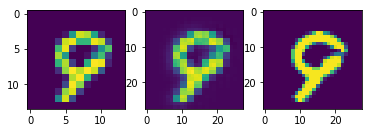

100 [D loss: 0.068334, acc.: 100.00%] [G loss: 3.320044]


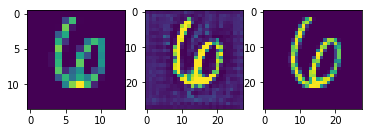

200 [D loss: 0.446219, acc.: 77.00%] [G loss: 2.212498]


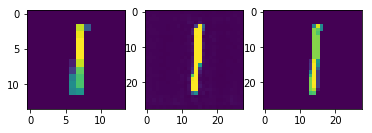

300 [D loss: 0.169095, acc.: 96.00%] [G loss: 2.890629]


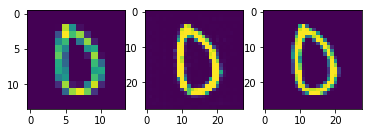

400 [D loss: 0.153654, acc.: 99.00%] [G loss: 4.215397]


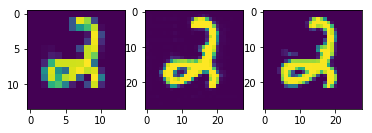

500 [D loss: 1.676674, acc.: 46.00%] [G loss: 3.262836]


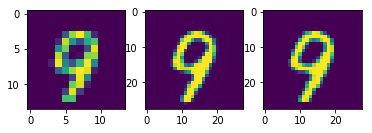

600 [D loss: 1.354320, acc.: 32.00%] [G loss: 1.406253]


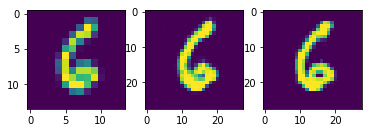

700 [D loss: 0.159472, acc.: 99.00%] [G loss: 2.381629]


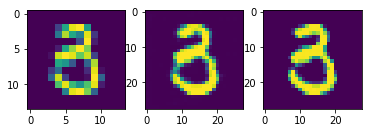

800 [D loss: 0.517724, acc.: 74.00%] [G loss: 1.933729]


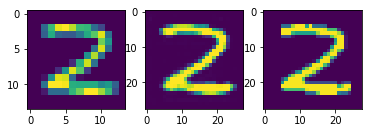

900 [D loss: 0.881110, acc.: 45.00%] [G loss: 2.941586]


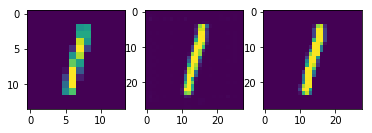

In [5]:
epochs = 1000
batch_size = 100
half_batch = int(batch_size/2)
def reduce_resolution(ims):
    O, M, N, P = ims.shape
    K = 2
    L = 2

    MK = M // K
    NL = N // L
    return ims.reshape(-1, MK, K, NL, L).mean(axis=(2, 4)).reshape(O, MK, NL, P)

# Unused function...?
def upsize(ims):
    return ims.repeat(2, axis = 1).repeat(2, axis = 2)

for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random half batch of images
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]
    noise = reduce_resolution(imgs) # imgs dimensions should be divisible by 2?
    # TODO: Probably should change some of the variable names to something more accurate.

    idx1 = np.random.randint(0, X_train.shape[0], half_batch)
    imgs1 = X_train[idx1]
    noise1 = reduce_resolution(imgs1)

    # Generate a half batch of new images
    gen_imgs = generator.predict(noise1)
    # gen_imgs are now upsampled to original resolution
    
    # Train the discriminator
    d_loss_real = discriminator.train_on_batch([noise, imgs], np.ones((half_batch, 1)))
    # Recall: imgs are random selection of actual MNIST images
    #    and noise = reduce_resolution(imgs)
    
    d_loss_fake = discriminator.train_on_batch([noise1, gen_imgs], np.zeros((half_batch, 1)))
    # Recall: noise1 = reduce_resolution(imgs1)
    #    and gen_imgs = generator(noise1)
    
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------

    idx2 = np.random.randint(0, X_train.shape[0], batch_size)
    noise2 = reduce_resolution(X_train[idx2])

    # The generator wants the discriminator to label the generated samples
    # as valid (ones)
    valid_y = np.array([1] * batch_size)
    
    # Train the generator
    g_loss = combined.train_on_batch(noise2, [valid_y, X_train[idx2]])
        
    if epoch % 100 == 0:
        # Plot the progress
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0]))
        fig, ax = plt.subplots(1, 3)
        ax[0].imshow(np.reshape(noise1[0], (14, 14)))
        ax[1].imshow(np.reshape(gen_imgs[0], (28, 28)))
        ax[2].imshow(np.reshape(imgs1[0], (28, 28)))
        plt.show()


In [6]:
generator.save('./models/generator_mnist.h5')
discriminator.save('./models/discriminator_mnist.h5')
combined.save('./models/combined_mnist.h5')